# Problem 6.1
# Part c
Attribution: Elena and Shashank

First we import the necessary modules and read in the data.

In [361]:
import itertools
import warnings
import time

# Our numerical workhorses
import numpy as np
from numpy import trapz
import pandas as pd
import scipy.stats as st
import scipy.special

# The MCMC Hammer
import emcee

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [499]:
df = pd.read_csv("./data/gardner_hw6/gardner_mt_catastrophe_only_tubulin.csv", comment="#")

Traceback (most recent call last):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-500-e44b631514be>", line 1, in <module>
    df = pd.read_csv("./data/gardner_hw6/gardner_mt_catastrophe_only_tubulin.csv", comment="#")
  File "//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py", line 491, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py", line 268, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py", line 583, in __init__
    self._make_engine(self.engine)
  File "//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py", line 724, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "//anaconda/lib/python3.5/site-packages/pandas/io/parsers.py", line 1093, in __

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.


Unfortunately, your original traceback can not be constructed.



TypeError: 'NoneType' object is not iterable

Let's take a quick look.

In [268]:
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35,25,50,60
1,40.000,45,40,60,75
2,40.000,50,40,60,75
3,45.429,50,45,75,85
4,50.000,55,50,75,115


We define the log likelihood for PTMCMC as the following:

\begin{align}
P(\left\{t_i\right\}\mid \{\tau_j\}, m, I) = \prod_i P(t_i\mid \{\tau_j\}, m, I),\,\,\text{where}
\end{align}

\begin{align}
P(t_i\mid \{\tau_j\}, m, I) = \sum_{j=1}^m \frac{\tau_j^{m-2}\,\mathrm{e}^{-t_i/\tau_j}}{\prod_{k=1,k\ne j}^m (\tau_j - \tau_k)}.
\end{align}

For the prior, we use Jeffreys priors for all $\tau_j$ because $\tau$ is a scale parameter. We also normalize the prior in order to use PTMCMC for parameter estimation. In the prior, we also ensure that $\{\tau_j\}$ is ordered least to greatest (we reject it if it is not) and that all $\tau_j$ are within the boundaries we defined as the minimum and maximum reasonable values. (We chose 1 second as the minimum and 1800 seconds as the maximum since those values encompass the range of observed catastrophe times.)

We also wrote a function to generate starting values for $\{\tau_j\}$ for any value of $m$. We decided to draw from an exponential distribution with mean = 300 because the mean catastrophe time was ~380, and we figured that $\tau$ should therefore be on the order of ~300-400 at least in the case of $m = 1$. 

In [499]:
def log_likelihood(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    We are very proud of this function.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return the sum of the log likelihoods
    return np.sum(log_like)

def log_prior(tau, m, tau_min, tau_max):
    """
    Log prior for model defined above. Takes in m and tau, 
    returns log prior.
    """
    # check that tau is ordered least to greatest;
    # also make sure the gap between each pair of tau values is
    # at least 1e-6 to help avoid precision issues when
    # calculating the log likelihood
    for i in range(m-1):
        if not (tau[i] + 1e-6) < tau[i+1]:
            return -np.inf
    
    # check that tau is not outside the boundaries we define
    if tau[0] < tau_min or tau[-1] > tau_max:
        return -np.inf
    
    prior = np.empty(m)
    # calculate and store the elements of the normalized prior 
    # associated with each tau 
    for i in range(m):
        if m == 1:
            prior[i] = tau[i] * np.log(tau_max / tau_min)
        
        elif m > 1 and i == 0:
            prior[i] = tau[i] * np.log(tau[i+1] / tau_min)
        
        elif m > 1 and i == m-1:
            prior[i] = tau[i] * np.log(tau_max / tau[i-1])
        
        else:
            prior[i] = tau[i] * np.log(tau[i+1] / tau[i-1])
            
    return -np.log(np.prod(prior))
        
def tau_start(m, n_walkers, n_temps):
    """
    Generates starting points for each tau.
    """
    p = np.empty((n_temps, n_walkers, m))
    
    for i in range(m):
        p[:,:,i] = np.random.exponential(300, (n_temps,n_walkers))
    return p

We wrote a function to help us run PTMCMC.

In [485]:
def sample_ptmcmc(data, m, model, tau_min=1, tau_max=1800, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using PTMCMC.
    """
    # arguments for likelihood
    loglargs = (data, m)
    
    # arguments for prior
    logpargs = (m, tau_min, tau_max)
    
    # starting points for the parameters
    p0 = tau_start(m, n_walkers, n_temps)
    
    # column headings for outputted DataFrames
    columns = {'m = 1': ['tau_1'],
               'm = 2': ['tau_1', 'tau_2'],
               'm = 3': ['tau_1', 'tau_2', 'tau_3'],
               'm = 4': ['tau_1', 'tau_2', 'tau_3', 'tau_4'],
               'm = 5': ['tau_1', 'tau_2', 'tau_3', 'tau_4', 'tau_5']}
    
    return bebi103.run_pt_emcee(
            log_likelihood, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            threads=threads, columns=columns[model], return_lnZ=True)

In [6]:
start = time.time()
df_1, lnZ_1, dlnZ_1 = sample_ptmcmc(df['12 uM'], 1, 'm = 1', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The first PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_2, lnZ_2, dlnZ_2 = sample_ptmcmc(df['12 uM'], 2, 'm = 2', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The second PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_3, lnZ_3, dlnZ_3 = sample_ptmcmc(df['12 uM'], 3, 'm = 3', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The third PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_4, lnZ_4, dlnZ_4 = sample_ptmcmc(df['12 uM'], 4, 'm = 4', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The fourth PTMCMC took ', time.time()-start, ' seconds.')

start = time.time()
df_5, lnZ_5, dlnZ_5 = sample_ptmcmc(df['12 uM'], 5, 'm = 5', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=1000, n_steps=5000, threads=3)
print('The fifth PTMCMC took ', time.time()-start, ' seconds.')

The first PTMCMC took  1116.4163601398468  seconds.
The second PTMCMC took  1351.2568359375  seconds.
The third PTMCMC took  1094.7742569446564  seconds.
The fourth PTMCMC took  1206.7325630187988  seconds.
The fifth PTMCMC took  843.8138411045074  seconds.


Let's take a look at the results using `corner` plots.

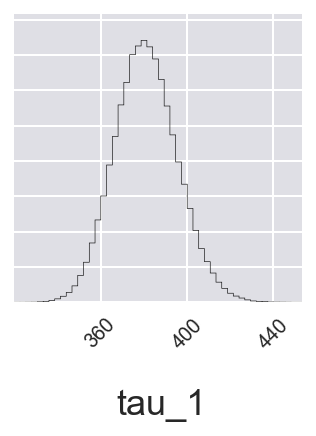

In [382]:
_ = corner.corner(df_1[df_1.beta_ind==0][['tau_1']], bins=50)

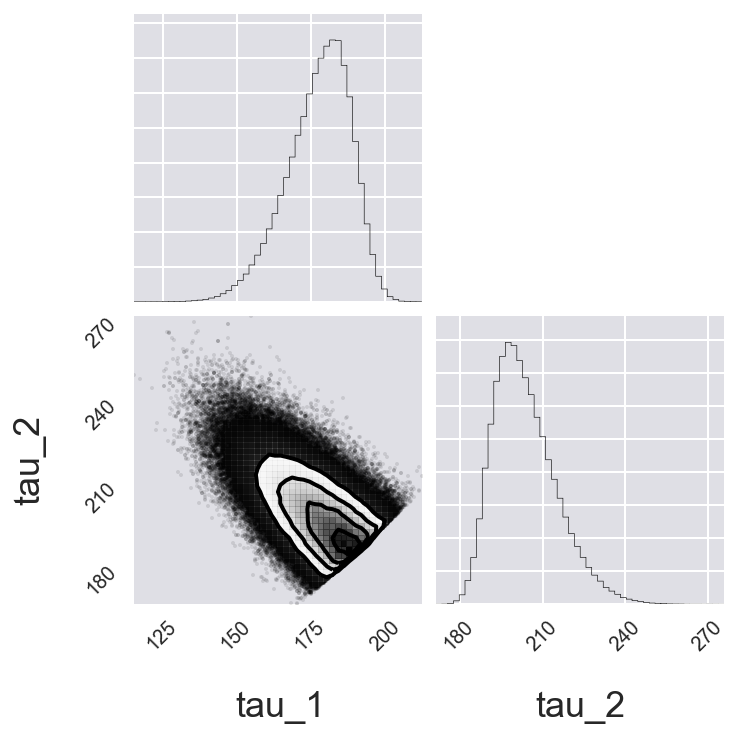

In [383]:
_ = corner.corner(df_2[df_2.beta_ind==0][['tau_1', 'tau_2']], bins=50)

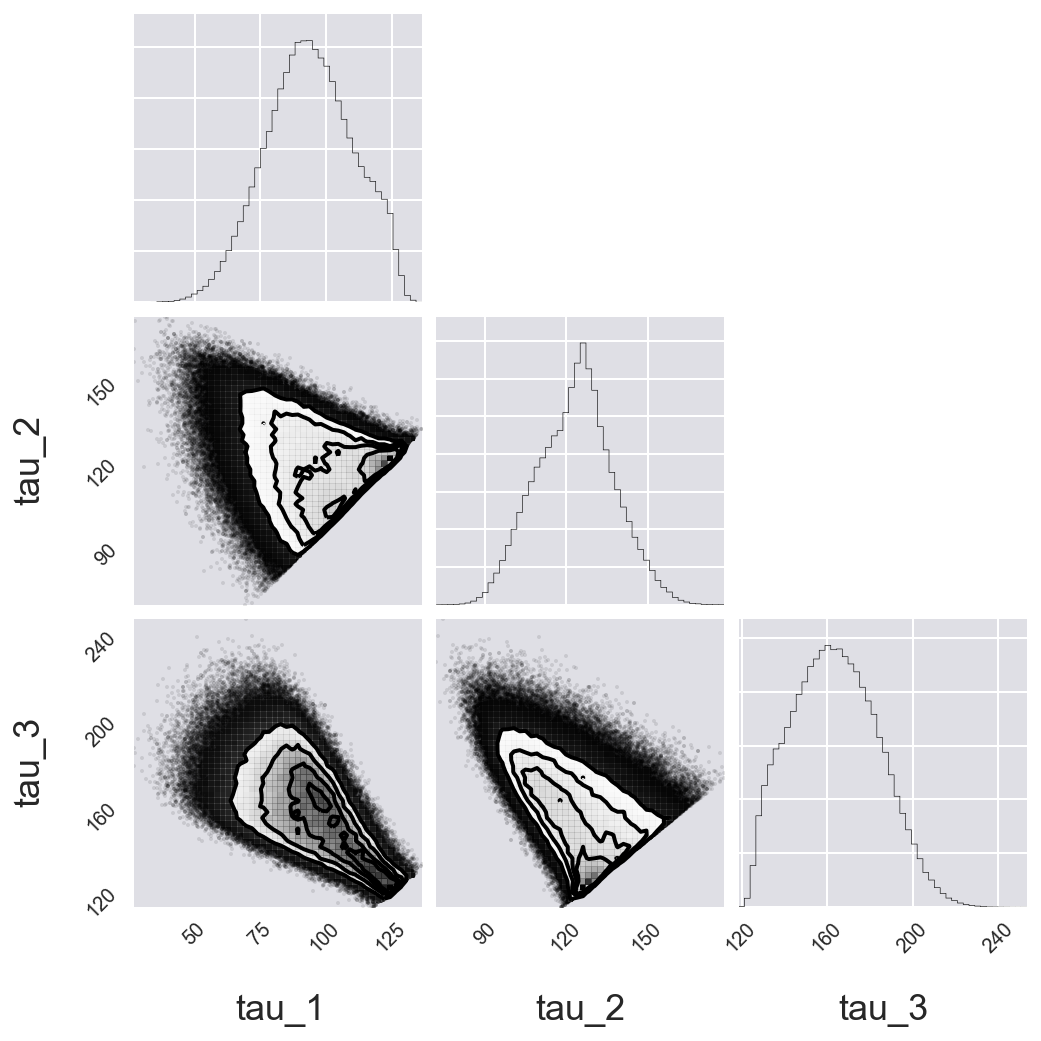

In [384]:
_ = corner.corner(df_3[df_3.beta_ind==0][['tau_1', 'tau_2', 'tau_3']], bins=50)

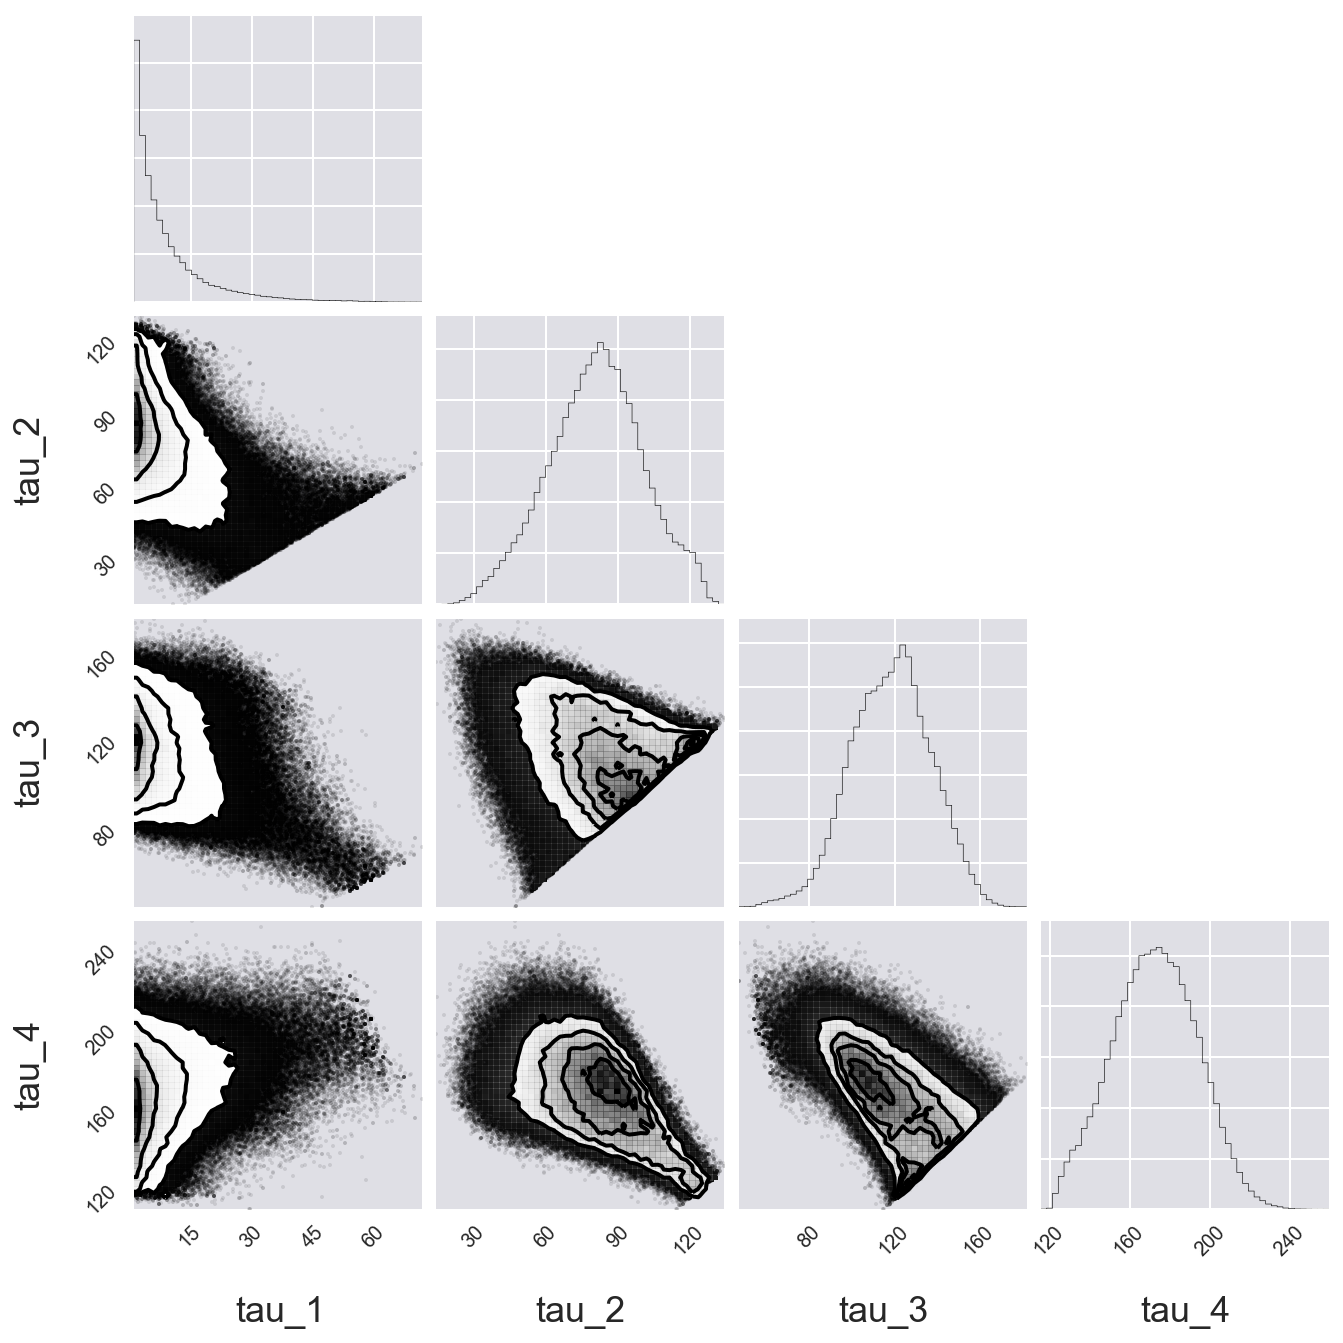

In [385]:
_ = corner.corner(df_4[df_4.beta_ind==0][['tau_1', 'tau_2', 'tau_3', 'tau_4']], bins=50)

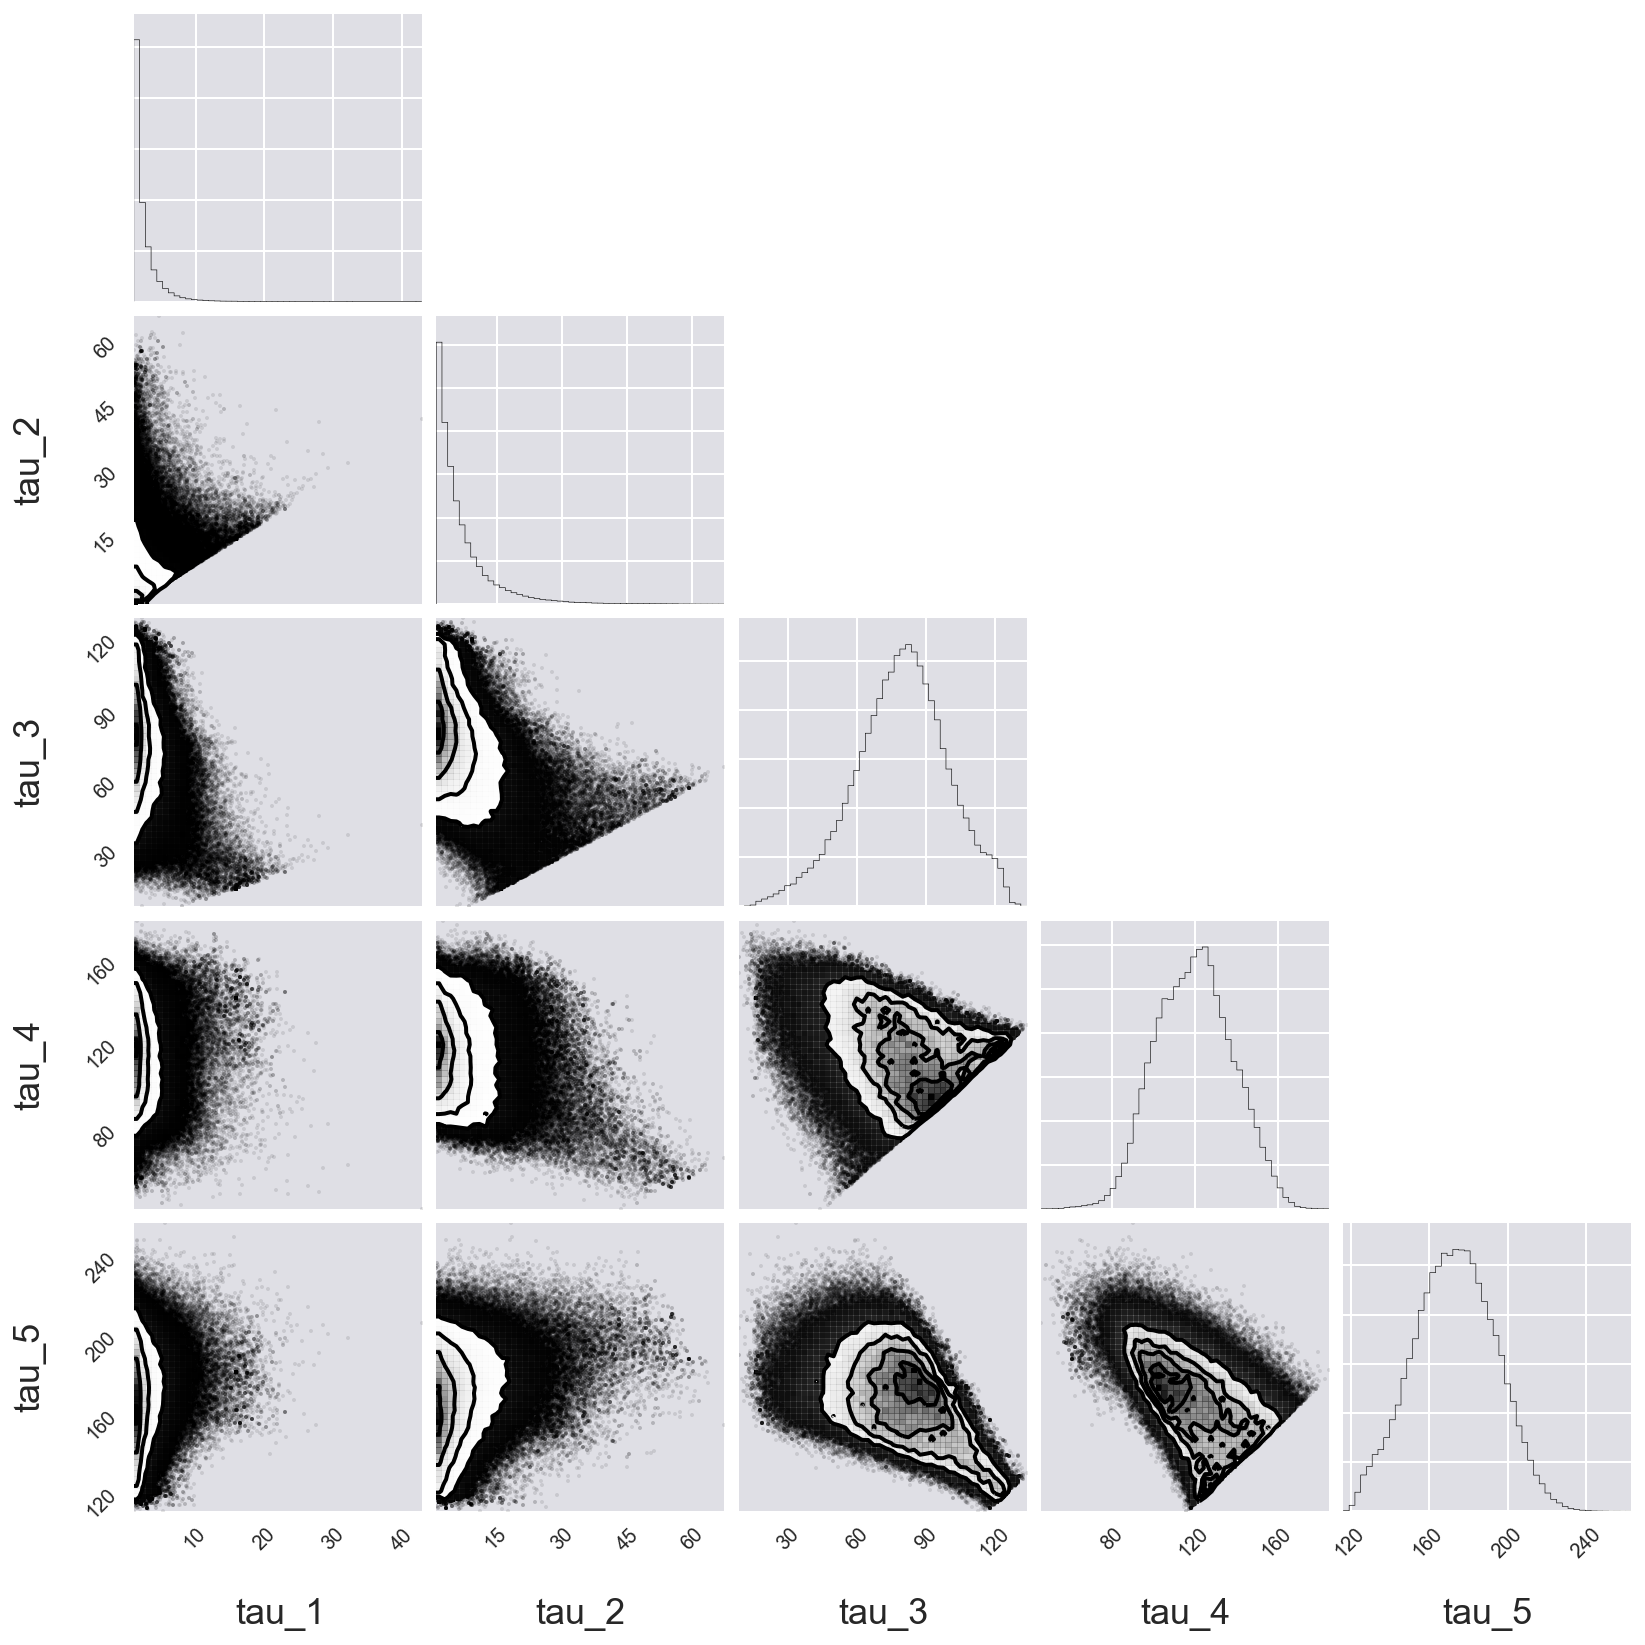

In [386]:
_ = corner.corner(df_5[df_5.beta_ind==0][['tau_1', 'tau_2', 'tau_3', 'tau_4', 'tau_5']], bins=50)

It is interesting that for $m > 3$, the smallest values of $\tau_j$ start to look exponentially distributed with the means at relatively small values, rather than having unimodal posteriors. Our intuition at this point was that this could mean there is little benefit to adding more $\tau$s after $m = 3$. 

So, we next wanted to calculate the odds ratios for our models. However, `lnZ` for each of our models was returned as `-inf`. In the course of troubleshooting this issue, one of the first things we did was take a look at the end of the PTMCMC `DataFrame` for one of our models.

In [387]:
df_3.tail()

,tau_1,tau_2,tau_3,lnlike,lnprob,beta_ind,beta,chain
9999995,60.211536,1299.638093,56.443691,-inf,NaN,19,4.314151e-13,99
9999996,60.211536,1299.638093,56.443691,-inf,NaN,19,4.314151e-13,99
9999997,60.211536,1299.638093,56.443691,-inf,NaN,19,4.314151e-13,99
9999998,60.211536,1299.638093,56.443691,-inf,NaN,19,4.314151e-13,99
9999999,60.211536,1299.638093,56.443691,-inf,NaN,19,4.314151e-13,99


This was very strange to us: we should not be getting `-inf` for any of our log likelihoods. Moreover, we found that more than half of our samples had this issue: 

In [498]:
print("""Percentage of samples with lnlike = -inf: {0:.2f}%""".\
      format(100 - (len(df_3[df_3.lnlike != -np.inf]) / len(df_3) * 100)))

Percentage of samples with lnlike = -inf: 55.37%


We double- and triple-checked our log likelihood function. While it could return `-inf` if `scipy.misc.logsumexp` returns a 0 at any point, this does not appear to be the problem here because if we run our `log_likelihood` function with the values of `tau_1`, `tau_2`, and `tau_3` recorded for the last sample (for which `lnlike` was reported as `-inf`), we get a finite value:

In [392]:
log_likelihood(df_3.values[-1][:3], df['12 uM'], 3)

-5200.6167192704597

However, we note that our values of $\tau_j$ are not in proper ranked order for those samples that have `lnlike = -inf`. (This appeared to be generally true, although above we only show the end of the `DataFrame` as an example.) This was again surprising to us because we had thought `emcee` would not record samples for which the prior was evaluated as `-inf`. Just to double-check our prior, we ran our `log_prior` function with the same values of `tau` we tested in the `log_likelihood` function above, and as expected, we got `-inf`. This prompted us to look at the [source code](https://github.com/dfm/emcee/blob/master/emcee/ptsampler.py) for the PT sampler in `emcee`. We discovered in lines 90-94 that in the case of the log prior returning `-inf`, `emcee` records both the log likelihood and the log prior as `-inf` (it does not actually evaluate the log likelihood function in this case - which indeed it shouldn't). Then, reading carefully lines 252-270 and 318-362, we found that when `emcee` evaluates whether to accept a step, it definitely rejects the step if the log prior is `-inf`; however, unless we are misinterpreting the code, it seems that the log likelihood for that sample would also still be recorded as `-inf`. 

At this point, we began to think that we might need to just drop all of the samples with `lnlike = -inf` from our PTMCMC `DataFrame` before calculating `lnZ`, since those samples should have been rejected anyway. Dropping these samples will not affect our posterior distributions since we only take the distributions from the first temperature, which does not have any `lnlike = -inf`. We confirmed this by making the corner plot again after dropping all rows with `-inf`.

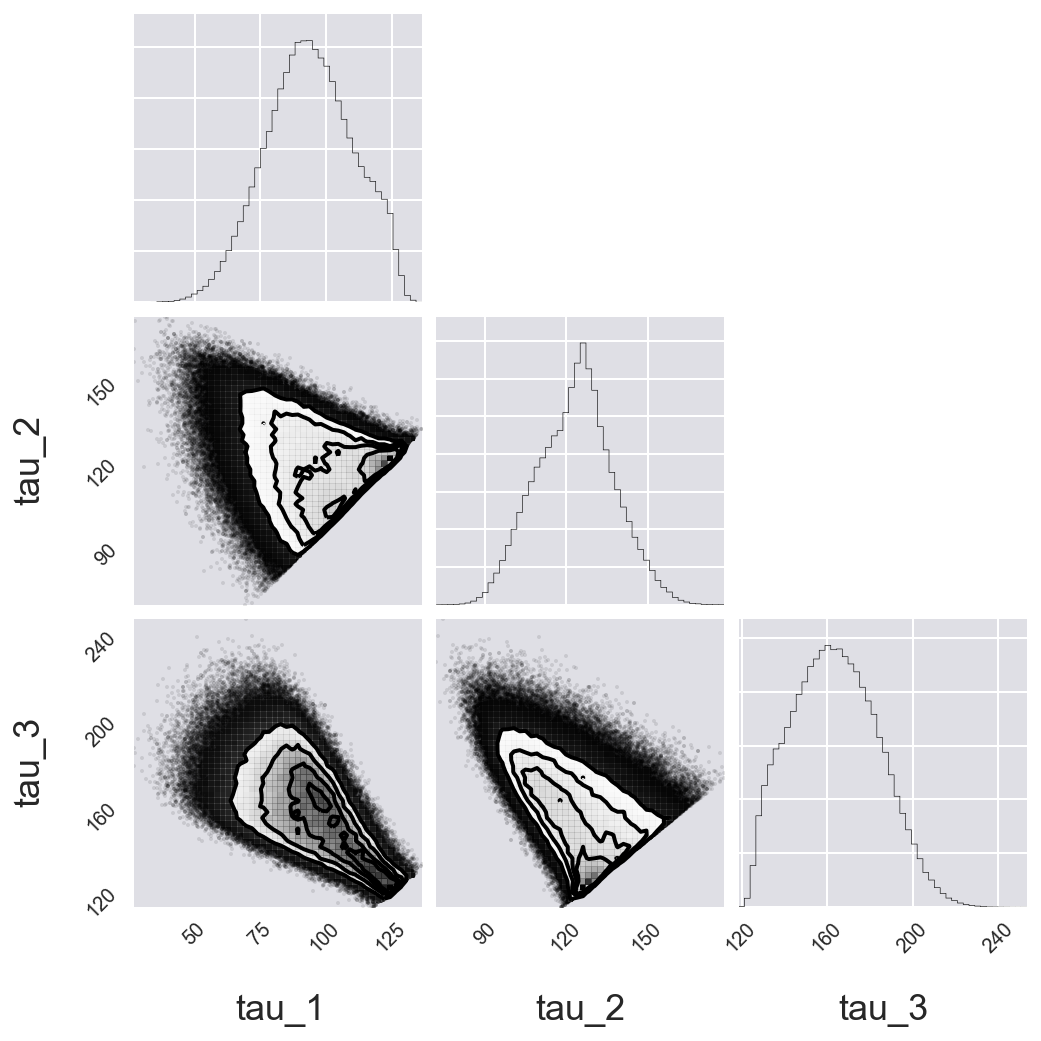

In [393]:
_ = corner.corner(df_3[(df_3.beta_ind==0) & (df_3.lnlike != -np.inf)][['tau_1', 'tau_2', 'tau_3']], bins=50)

So then for each model, we took the `DataFrame` without the problematic samples and calculated `lnZ` using Justin's handy function that was posted on Piazza.

In [394]:
df1_no_inf = df_1[df_1['lnlike'] != -np.inf]
df2_no_inf = df_2[df_2['lnlike'] != -np.inf]
df3_no_inf = df_3[df_3['lnlike'] != -np.inf]
df4_no_inf = df_4[df_4['lnlike'] != -np.inf]
df5_no_inf = df_5[df_5['lnlike'] != -np.inf]

def lnZ(df_mcmc):
    """
    Compute log Z(1) from PTMCMC traces stored in DataFrame.
    """
    # Average the log likelihood over the samples
    log_mean = np.zeros(len(df_mcmc['beta_ind'].unique()))
    for i, b in enumerate(df_mcmc['beta_ind'].unique()):
        log_mean[i] = df_mcmc['lnlike'][df_mcmc['beta_ind']==b].mean()

    # Set of betas (temperatures)
    betas = np.concatenate((np.array(df_mcmc['beta'].unique()), (0,)))

    # Approximate quadrature
    return -np.dot(log_mean, np.diff(betas))

lnz1 = lnZ(df1_no_inf)
lnz2 = lnZ(df2_no_inf)
lnz3 = lnZ(df3_no_inf)
lnz4 = lnZ(df4_no_inf)
lnz5 = lnZ(df5_no_inf)

Now we can calculate odds ratios.

In [395]:
print('Odds ratio for m = 1 vs m = 2:', np.exp(lnz1 - lnz2))
print('Odds ratio for m = 2 vs m = 3:', np.exp(lnz2 - lnz3))
print('Odds ratio for m = 3 vs m = 4:', np.exp(lnz3 - lnz4))

Odds ratio for m = 1 vs m = 2: 1.87662293233e-61
Odds ratio for m = 2 vs m = 3: 1.52155085892e-11
Odds ratio for m = 3 vs m = 4: 1.99614007289


So far it looks like $m = 3$ gives the best model. Just to double-check, let's calculate the odds ratio for $m = 3$ vs $m = 5$. 

In [396]:
print('Odds ratio for m = 3 vs m = 5:', np.exp(lnz3 - lnz5))

Odds ratio for m = 3 vs m = 5: 6119.16456482


So it looks like $m = 3$ does indeed give the best model. Actually, there is not much of a difference between $m = 3$, $m = 4$, and $m = 5$. However, in part (d) we will stick with $m = 3$ since it does have the best odds of those three due to being the least complex model. 

Next we attempted to get the MAP for each $\tau_j$ in the $m = 3$ model by restricting our PTMCMC `DataFrame` to the first temperature and finding the row with the highest value for `lnprob`. However, this gave us values which did not at all correspond to the peaks of our histograms for the marginalized posterior distributions of $\tau_1$, $\tau_2$, and $\tau_3$.  

In [403]:
# Get the index of the most probable parameter set
df3_map = df_3[(df_3.beta_ind==0) & (df_3.lnlike != -np.inf)]
max_ind = np.argmax(df3_map.lnprob.values)

# Pull out values.
tau1_MAP, tau2_MAP, tau3_MAP = df3_map.values[max_ind, :3]

# Print the results
print("""Most probable parameter values for m = 3:
tau_1:  {0:.3f}
tau_2: {1:.3f}
tau_3: {2:.3f}""".format(tau1_MAP, tau2_MAP, tau3_MAP))

Most probable parameter values for m = 3:
tau_1:  128.555
tau_2: 128.575
tau_3: 128.636


This seemed very strange to us, but even after talking with the TAs, we couldn't figure out why this was happening - although we suspect something is wrong with our definition of the prior, we could not find the error (and neither could the TA). So, we decided instead to calculate the MAP as the median value for each $\tau_j$. We calculated the MAPs for $\tau_j$ for each of our five models so that we would be able to plot all five on top of the data.

In [414]:
df1_map = df_1[(df_1.beta_ind==0) & (df_1.lnlike != -np.inf)]
df2_map = df_2[(df_2.beta_ind==0) & (df_2.lnlike != -np.inf)]
df4_map = df_4[(df_4.beta_ind==0) & (df_4.lnlike != -np.inf)]
df5_map = df_5[(df_5.beta_ind==0) & (df_5.lnlike != -np.inf)]

tau_map1 = np.array([df1_map['tau_1'].median()])
tau_map2 = np.array([df2_map['tau_1'].median(), df2_map['tau_2'].median()])
tau_map3 = np.array([df3_map['tau_1'].median(), df3_map['tau_2'].median(),
                     df3_map['tau_3'].median()])
tau_map4 = np.array([df4_map['tau_1'].median(), df4_map['tau_2'].median(),
                     df4_map['tau_3'].median(), df4_map['tau_4'].median()])
tau_map5 = np.array([df5_map['tau_1'].median(), df5_map['tau_2'].median(),
                     df5_map['tau_3'].median(), df5_map['tau_4'].median(), 
                     df5_map['tau_5'].median()])

# Print the MAPs
print("""Most probable parameter value for m = 1:
tau_1: {0:.3f} seconds
""".format(tau_map1[0]))

# Print the MAPs
print("""Most probable parameter values for m = 2:
tau_1: {0:.3f} seconds
tau_2: {1:.3f} seconds
""".format(tau_map2[0], tau_map2[1]))

# Print the MAPs
print("""Most probable parameter values for m = 3:
tau_1: {0:.3f} seconds
tau_2: {1:.3f} seconds
tau_3: {2:.3f} seconds
""".format(tau_map3[0], tau_map3[1], tau_map3[2]))

# Print the MAPs
print("""Most probable parameter values for m = 4:
tau_1: {0:.3f} seconds
tau_2: {1:.3f} seconds
tau_3: {2:.3f} seconds
tau_4: {3:.3f} seconds
""".format(tau_map4[0], tau_map4[1], tau_map4[2], tau_map4[3]))

# Print the MAPs
print("""Most probable parameter values for m = 5:
tau_1: {0:.3f} seconds
tau_2: {1:.3f} seconds
tau_3: {2:.3f} seconds
tau_4: {3:.3f} seconds
tau_5: {4:.3f} seconds
""".format(tau_map5[0], tau_map5[1], tau_map5[2], tau_map5[3], tau_map5[4]))

Most probable parameter value for m = 1:
tau_1: 380.652 seconds

Most probable parameter values for m = 2:
tau_1: 178.752 seconds
tau_2: 202.140 seconds

Most probable parameter values for m = 3:
tau_1: 93.762 seconds
tau_2: 123.942 seconds
tau_3: 163.070 seconds

Most probable parameter values for m = 4:
tau_1: 5.825 seconds
tau_2: 81.428 seconds
tau_3: 118.971 seconds
tau_4: 172.587 seconds

Most probable parameter values for m = 5:
tau_1: 1.798 seconds
tau_2: 4.553 seconds
tau_3: 79.827 seconds
tau_4: 119.713 seconds
tau_5: 173.011 seconds



At this point we noticed something pretty interesting: the most probable values of $\tau_j$ look like they sum to approximately the same value regardless of the model. In fact, this value turns out to be the mean observed catastrophe time:

In [416]:
print("""MAP of tau for m = 1: {0:.3f} seconds""".format(tau_map1[0]))
print("""Sum of MAPs of taus for m = 2: {0:.3f} seconds""".format(np.sum(tau_map2)))
print("""Sum of MAPs of taus for m = 3: {0:.3f} seconds""".format(np.sum(tau_map3)))
print("""Sum of MAPs of taus for m = 4: {0:.3f} seconds""".format(np.sum(tau_map4)))
print("""Sum of MAPs of taus for m = 5: {0:.3f} seconds""".format(np.sum(tau_map5)))
print("""
Mean catastrophe time for 12 µM tubulin: {0:.3f} seconds""".format(df['12 uM'].mean()))

MAP of tau for m = 1: 380.652 seconds
Sum of MAPs of taus for m = 2: 380.892 seconds
Sum of MAPs of taus for m = 3: 380.774 seconds
Sum of MAPs of taus for m = 4: 378.811 seconds
Sum of MAPs of taus for m = 5: 378.901 seconds

Mean catastrophe time for 12 µM tubulin: 380.554 seconds


We hadn't thought about whether to expect this beforehand, but we guess it could make sense that the total time for all of the subproccesses should add up to the mean catastrophe time, if we assume that each subprocess does not start until the previous one has completed. We think this is essentially what we assumed when setting up our mathematical model, since we defined the inverse rate for each subprocess ($\tau_j$) as the difference between the time of the previous process/event and the time of the next process. 

Next we wanted to plot our theoretical models as cumulative distribution functions on top of the data. To do so, we first defined a modified log likelihood function that calculates the likelihoods for individual catastrophe times and stores them in an array, rather than calculating a single likelihood for a set of catastrophe times.

In [420]:
def log_likelihood_t(tau, t, m):
    """
    Takes in tau (should be an array of length m), 
    data (Pandas data series), various values for m. 
    Returns the log_likelihoods for all datapoints 
    in an array.
    """   
    # set up array to store the log likelihoods calculated for each
    # value of t
    log_like = np.empty((len(t), 1))
    
    num_handler = np.empty((len(t), m)) # the numerator of the scaling factor
    exp_handler = np.empty((len(t), m)) # the exponent part of the numerators
    den_elem = np.empty(m) # temporary array to store elements of the denominator 
                           # of the scaling factor
    den_handler = np.empty((len(t), m)) # denominator of the scaling factor
    
    # iterate over j for all data points 
    for j in range(m):
        num_handler[:,j] = tau[j]**(m-2)
        exp_handler[:,j] = -t/tau[j]
        den_elem = tau[j] - tau
        # use only non-zero elements when taking the product 
        # in the denominator of the scaling factor 
        den_prod = np.prod(den_elem[:j]) * np.prod(den_elem[j+1:])
        den_handler[:,j] = den_prod 
        den_elem = np.empty(m)

    scaling_factor = num_handler / den_handler

    # store the log likelihoods in an array 
    log_like = scipy.misc.logsumexp(exp_handler, axis=1, b=scaling_factor)            

    # return array of the log likelihoods
    return log_like

Then we defined our posterior distribution as the exponentiated sum of the log likelihoods and log priors. To convert the posterior distributions into CDFs, we normalized each by the area under the curve and calculated the cumulative sums. 

In [400]:
def post_plot(tau, t, m, tau_min, tau_max):
    return np.exp(log_likelihood_t(tau, t, m) + log_prior(tau, m, tau_min, tau_max))

post1 = post_plot(tau_map1, np.arange(1800), 1, 1, 1800)
post1_area = trapz(post1, dx=1)
post1_norm = post1 / post1_area
post1_cdf = np.cumsum(post1_norm)

post2 = post_plot(tau_map2, np.arange(1800), 2, 1, 1800)
post2_area = trapz(post2, dx=1)
post2_norm = post2 / post2_area
post2_cdf = np.cumsum(post2_norm)

post3 = post_plot(tau_map3, np.arange(1800), 3, 1, 1800)
post3_area = trapz(post3, dx=1)
post3_norm = post3 / post3_area
post3_cdf = np.cumsum(post3_norm)

post4 = post_plot(tau_map4, np.arange(1800), 4, 1, 1800)
post4_area = trapz(post4, dx=1)
post4_norm = post4 / post4_area
post4_cdf = np.cumsum(post4_norm)

post5 = post_plot(tau_map5, np.arange(1800), 5, 1, 1800)
post5_area = trapz(post5, dx=1)
post5_norm = post5 / post5_area
post5_cdf = np.cumsum(post5_norm)

Finally we plotted the empirical CDF (the data) with the theoretical CDFs.

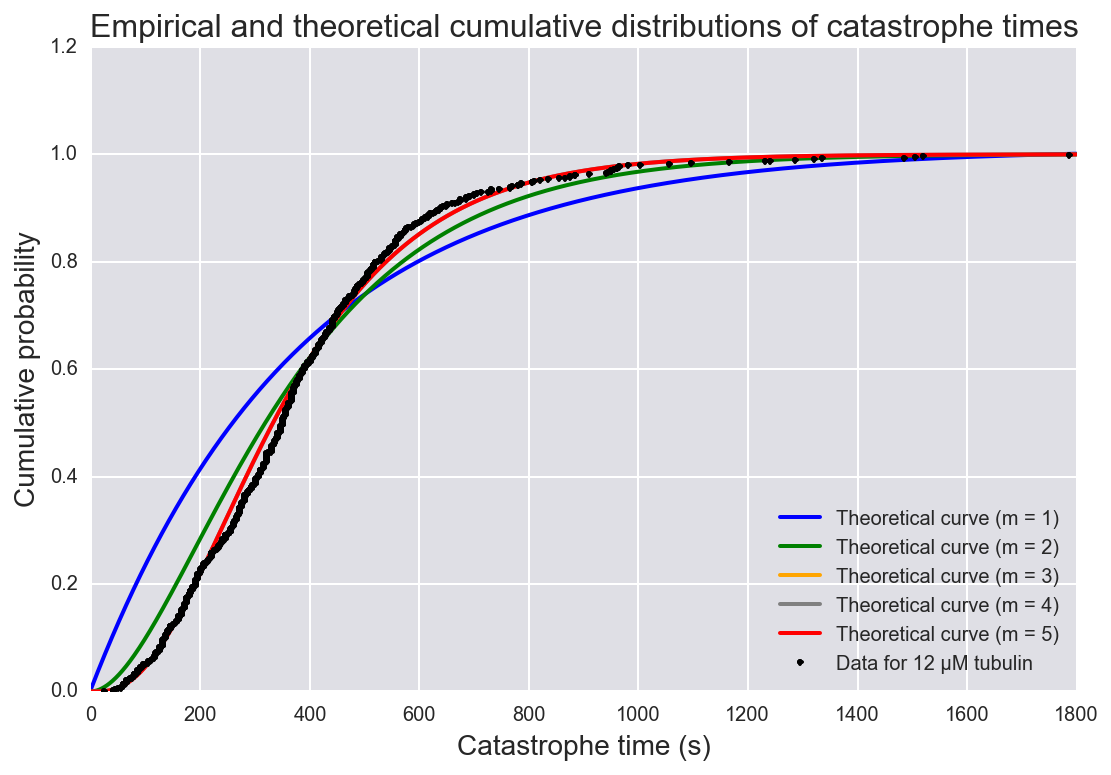

In [401]:
# Build ECDF
y = np.arange(len(df['12 uM'])) / len(df['12 uM'])
x = np.sort(df['12 uM'].values)

# Plot ECDF and theoretical CDFs for different values of m
plt.plot(np.arange(1800), post1_cdf, color='blue')
plt.plot(np.arange(1800), post2_cdf, color='green')
plt.plot(np.arange(1800), post3_cdf, color='orange')
plt.plot(np.arange(1800), post4_cdf, color='gray')
plt.plot(np.arange(1800), post5_cdf, color='red')
plt.plot(x, y, '.', color='k')
plt.xlabel('Catastrophe time (s)', fontsize=14)
plt.ylabel('Cumulative probability', fontsize=14)
plt.title('Empirical and theoretical cumulative distributions of catastrophe times',
          fontsize=16)
plt.legend(['Theoretical curve (m = 1)', 'Theoretical curve (m = 2)',
            'Theoretical curve (m = 3)', 'Theoretical curve (m = 4)', 
            'Theoretical curve (m = 5)', 'Data for 12 µM tubulin'], loc=4)
plt.tight_layout()

As expected from the odds ratios, $m = 3$, $m = 4$, and $m = 5$ give the best fits (they are so similar, in fact, that they obscure each other). These three models look pretty close to the empirical CDF, so our model and MAPs seem reasonable despite the trouble we had to go through to get them. 